In [34]:
from data_prep import prepare_datasets, get_dfs
import random
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import sklearn

%load_ext autoreload
%autoreload 2

seed = 42
random.seed(seed)
np.random.seed(seed)

LABELS = {0: "clear",
          1: "light cloud",
          2: "overcast",
          3: "light rain",
          4: "heavy rain",
          5: "storm"}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read Data

In [35]:
single_val_cols = [
    "M_FORECAST_ACCURACY",
    "M_TOTAL_LAPS",
    'M_PIT_STOP_WINDOW_IDEAL_LAP',
    'M_PIT_STOP_WINDOW_LATEST_LAP',
    'M_PIT_STOP_REJOIN_POSITION',
    'M_STEERING_ASSIST',
    'M_BRAKING_ASSIST',
    'M_GEARBOX_ASSIST',
    'M_PIT_ASSIST',
    'M_PIT_RELEASE_ASSIST',
    'M_ERSASSIST',
    'M_DRSASSIST',
    'M_DYNAMIC_RACING_LINE',
    'M_DYNAMIC_RACING_LINE_TYPE'
]

multi_val_cols = [
    "M_WEATHER_FORECAST_SAMPLES_M_WEATHER",
    "M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE",
    "M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE",
    "M_TRACK_TEMPERATURE_CHANGE",
    "M_AIR_TEMPERATURE_CHANGE",
    "M_RAIN_PERCENTAGE"]


use_flag_info = False


In [36]:
if op.exists(op.join("data", "train.csv")) and op.exists(op.join("data", "val.csv")) and op.exists(op.join("data", "test.csv")):
    train_df = pd.read_csv(op.join("data", "train.csv"))
    val_df = pd.read_csv(op.join("data", "val.csv"))
    test_df = pd.read_csv(op.join("data", "test.csv"))
else:
    train_df, val_df, test_df = prepare_datasets(
        op.join("data", "weather.csv"), single_val_cols, multi_val_cols, use_flag_info=use_flag_info)
df_dct = {"train": train_df, "val": val_df, "test": test_df}
df_timed_dct = get_dfs(df_dct, single_val_cols, multi_val_cols)


Creating dataset for time_offset=5
Creating dataset for time_offset=10
Creating dataset for time_offset=15
Creating dataset for time_offset=30
Creating dataset for time_offset=60


# Exploratory Data Analysis

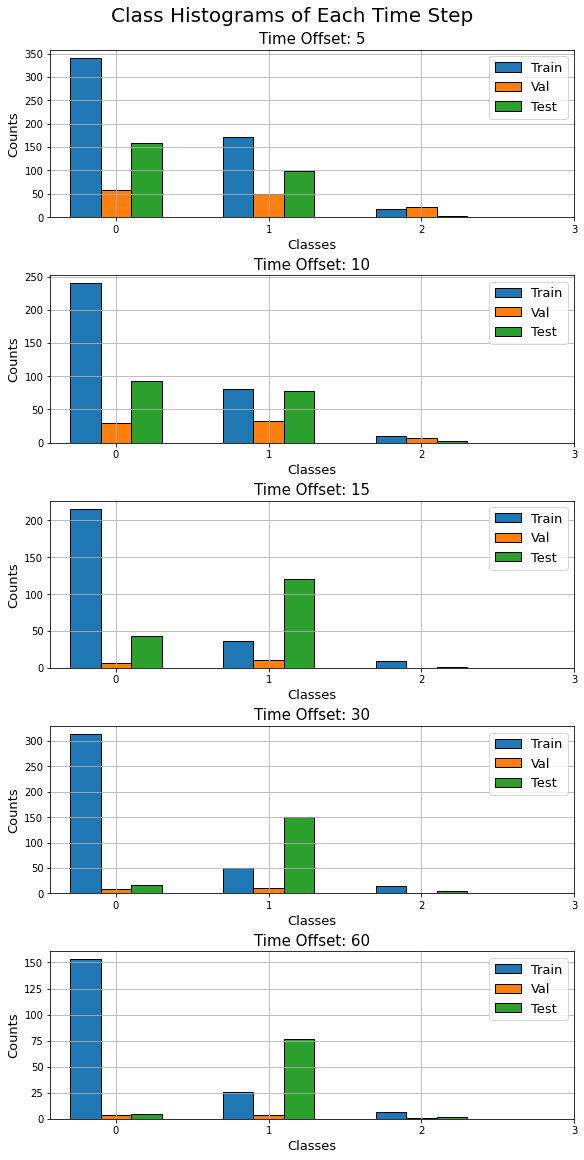

In [37]:
from plot import plot_class_histograms
import copy

CLASS_IDX_BOUNDARY = 2

_df_timed_dct = copy.deepcopy(df_timed_dct)

df_timed_dct_subset = {}
for time_offset, df_timed in _df_timed_dct.items():
    df_timed_dct_subset[time_offset] = {}
    for typ, d_set in df_timed.items():
        df_timed_dct_subset[time_offset][typ] = d_set[d_set['TARGET_WEATHER'] <= CLASS_IDX_BOUNDARY].copy()
fig = plot_class_histograms(df_timed_dct_subset, max_class_idx=CLASS_IDX_BOUNDARY+1)


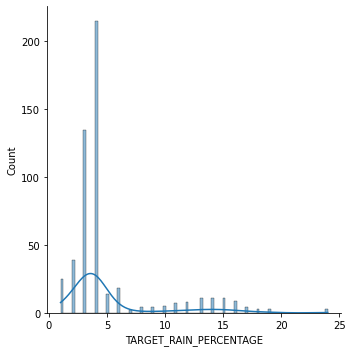

In [38]:
sns.displot(df_timed_dct["5"]["train"]["TARGET_RAIN_PERCENTAGE"],kde=True)


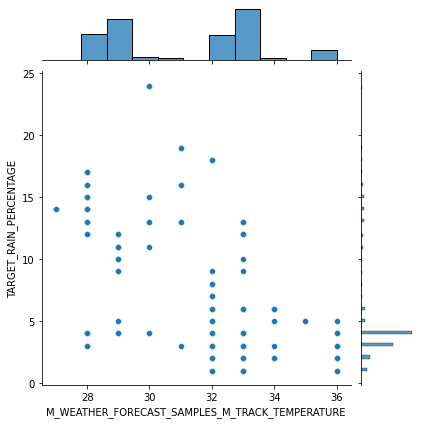

In [39]:
sns.jointplot(x="M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE",
 y="TARGET_RAIN_PERCENTAGE", data=df_timed_dct["5"]["train"])


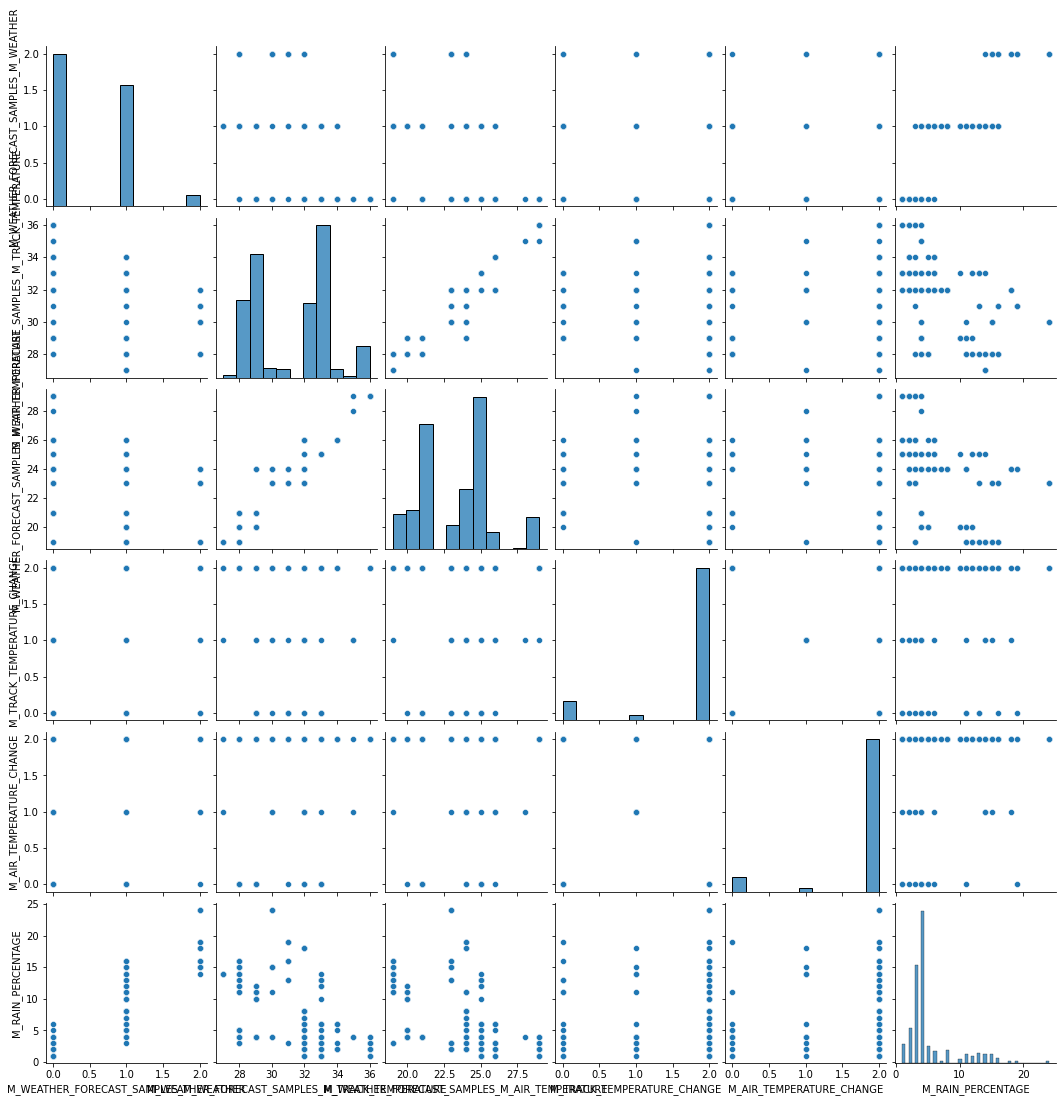

In [40]:
table = data = df_timed_dct["5"]["train"]
sns.pairplot(table[multi_val_cols])


# Model Training & Evaluation

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


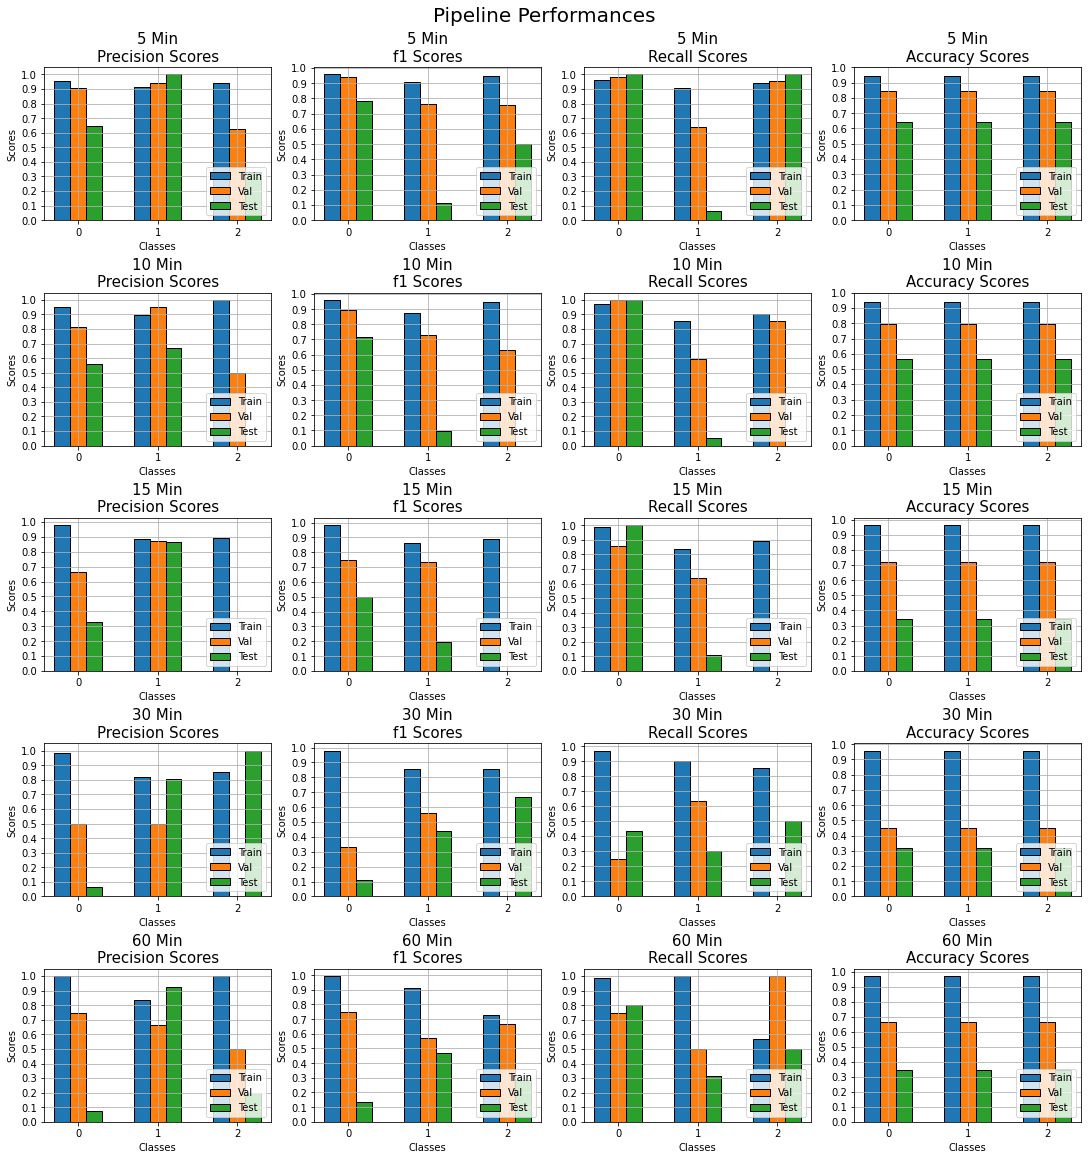

In [47]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from plot import plot_model_performance

model = RandomForestClassifier(max_depth=5, random_state=0)
pipeline = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
plot_model_performance(pipeline, df_timed_dct_subset, save=False)


# Export Model

In [16]:
class Model:
    def __init__(self, classifier_model, regressor_model, cols):
        self.time_offsets = ["5", "10", "15", "30", "60"]
        self.cols = cols
        self.classifiers = [sklearn.base.clone(
            classifier_model) for _ in range(5)]
        self.regressors = [sklearn.base.clone(
            regressor_model) for _ in range(5)]

    def fit(self, df_timed_dct):
        for i, time_offset in enumerate(self.time_offsets):
            table = df_timed_dct[time_offset]["train"]
            table = table[self.cols]
            X = table[table.columns[:-2]]
            weather = table[table.columns[-1]]
            rain_percent = table[table.columns[-2]]
            self.classifiers[i].fit(X, weather)
            self.regressors[i].fit(X, rain_percent)

    def predict(self, row):
        if np.sum(row.isna()) > 0:
            return np.nan
        weather_preds = [classifier.predict(
            [row[self.cols]]) for classifier in self.classifiers]
        rain_percent_preds = [regressor.predict(
            [row[self.cols]]) for regressor in self.regressors]
        return {ts: {'type': weather, str(weather): rain_percent}
                for ts, weather, rain_percent in zip(self.time_offsets, weather_preds, rain_percent_preds)}
